# DS542 - Spring 2026 - Discussion 3

In this notebook, we will explore the use of BU's Shared Computing Cluster (SCC) by training a simple neural network on the Pima Indians Diabetes dataset.

You can read more about the dataset on [our Github repo](https://github.com/DL4DS/sp2026_discussions/blob/main/datasets/pima-indians-diabetes-dataset/README.md) and on the SCC at `/projectnb/dl4ds/materials/datasets/pima-indians-diabetes-dataset/README.md`

Please [discussion_3_setu.md](https://github.com/DL4DS/sp2026_discussions/blob/main/discussion_3_setup.md) for set up instructions.

In [5]:
import os
import math
import socket
import psutil
import getpass
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
torch.__version__

'2.8.0+cu128'

### Exercise 1: Create a SCC session

In [4]:
# TODO: run this block to verify your scc environment

def verify_scc_environment():

    verification_info = {
        'hostname': socket.gethostname(),
        'username': getpass.getuser(), 
        'current_time': datetime.datetime.now().isoformat(),
        'python_path': os.path.dirname(os.__file__),
        'working_directory': os.getcwd(),
        'cuda_available': torch.cuda.is_available(),
        'cuda_device_count': torch.cuda.device_count() if torch.cuda.is_available() else 0,
        'cpu_count': psutil.cpu_count(),
        'memory_total_gb': round(psutil.virtual_memory().total / (1024**3), 2),
        'pytorch_version': torch.__version__
    }
    
    if 'scc' not in verification_info['hostname'].lower() and 'cluster' not in verification_info['hostname'].lower():
        print("Fail.")
    
    for key, value in verification_info.items():
        print(f"{key}: {value}")
    
    return verification_info

verify_info = verify_scc_environment()

hostname: scc-204
username: carrieff
current_time: 2025-09-22T11:58:03.567222
python_path: /share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12
working_directory: /projectnb/ds542/archive/carrieff
cuda_available: True
cuda_device_count: 1
cpu_count: 32
memory_total_gb: 187.04
pytorch_version: 2.8.0+cu128


### Exercise 2: Create a Tensor on GPU

In [1]:
# TODO: create a tensor on GPU using `device='cuda:0`

t_gpu = torch.tensor(__fill__)
print(t_gpu)

### Exercise 3: Impleting a CPU hard task on GPU device

In [2]:
n = 10000
i, k = 1234, 5678


# Build A, B on GPU via broadcasting
device = torch.device(__fill__)
rows = torch.arange(1, n+1, device=device, dtype=torch.float64).view(-1, 1)
cols = torch.arange(1, n+1, device=device, dtype=torch.float64).view(1, -1)

A = rows + cols                    # A_{ij} = i + j
B = cols.transpose(0,1) - cols     # B_{jk} = j - k


# TODO: multiply on GPU
C = __fill__  # 10k x 10k matrix multiplication, which is fast on GPU but painful on CPU.

val_gpu = C[i-1, k-1].item()
print(int(val_gpu))           

### Exercise 4: Read dataset from shared folder

Read the dataset from: `/projectnb/dl4ds/materials/datasets/pima-indians-diabetes-dataset/diabetes.csv`

In [ ]:
# TODO: run this block to import the CSV file from the shared folder

df = pd.read_csv('/projectnb/dl4ds/materials/datasets/pima-indians-diabetes-dataset/diabetes.csv')
df.head()

### Exercise 5: Train a Neural Network with above dataset

Neural Network Accuracy: 0.7969


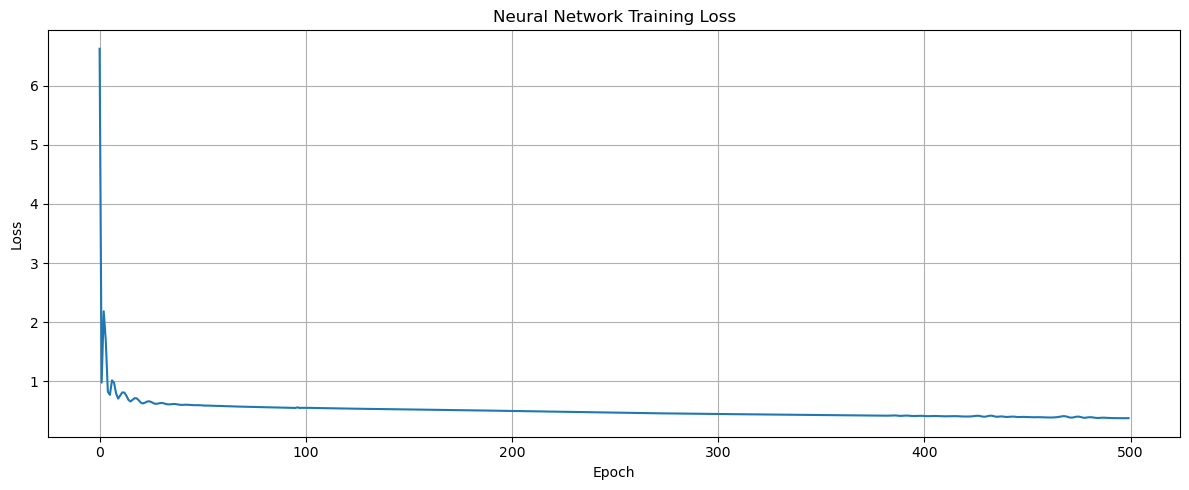

In [11]:
X = torch.tensor(df.drop("Outcome", axis=1).values, dtype=torch.float32)
y = torch.tensor(df["Outcome"].values, dtype=torch.float32).view(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# define a 2-layer NN
class ShallowNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X.shape[1], 8)
        self.fc2 = nn.Linear(8, 2)
        self.fc3 = nn.Linear(2, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))


#TODO: optimize/run the model by changing any params
model = ShallowNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

losses_nn = []


# Training
for epoch in range(5):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    losses_nn.append(loss.item())

# Predictions on the full dataset
with torch.no_grad():
    final_predictions_nn = model(X)

# Accuracy
predicted_classes_nn = (final_predictions_nn > 0.5).float()
accuracy_nn = (predicted_classes_nn == y).float().mean()
print(f"Neural Network Accuracy: {accuracy_nn:.4f}")


# Plot
plt.figure(figsize=(12, 5))

plt.plot(losses_nn)
plt.title('Neural Network Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()